# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
display(data0.head())
display(data1.head())
display(data2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
display(data0.info())
display(data1.info())
display(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [5]:
print('Размер датасета 0:', data0.shape)
print('Размер датасета 1:', data1.shape)
print('Размер датасета 2:', data2.shape)

Размер датасета 0: (100000, 5)
Размер датасета 1: (100000, 5)
Размер датасета 2: (100000, 5)


In [6]:
print('Пропуски в датасете 0:', data0.duplicated().sum())
print('Пропуски в датасете 1:', data1.duplicated().sum())
print('Пропуски в датасете 2:', data2.duplicated().sum())

Пропуски в датасете 0: 0
Пропуски в датасете 1: 0
Пропуски в датасете 2: 0


In [7]:
display(data0.nunique())
display(data1.nunique())
display(data2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [8]:
data1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

В датасете data1 в колонке 'product' только 12 уникальных значений. Складывается впечатление, что идентификатором обозначили время (дату) проверки объёмов запасов в 12-ти скважинах, тогда непонятно, почему разные характеристики (признаки). Так же имеются неуникальные 'id'. Пропусков и дубликатов в данных нет.

Посмотрим на данные с помощью describe и визуализируем данные.

In [9]:
def adventure_time(data, col):
    global title
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(data[col],ax=axs[0]).set_title(f'Датасет №{title}',fontsize=20);
    sns.boxplot(data[col], ax=axs[1]).set_title(f'Датасет №{title}',fontsize=20);  

### Датасет 0

In [10]:
display(data0.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


None

None

None

None

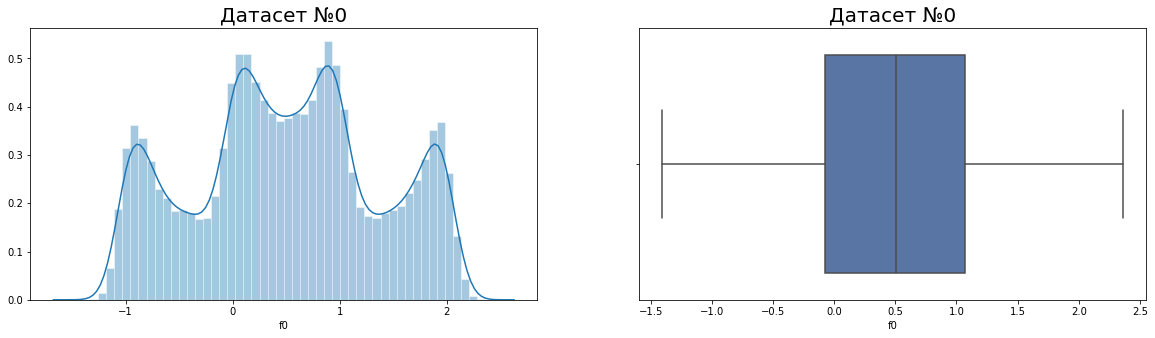

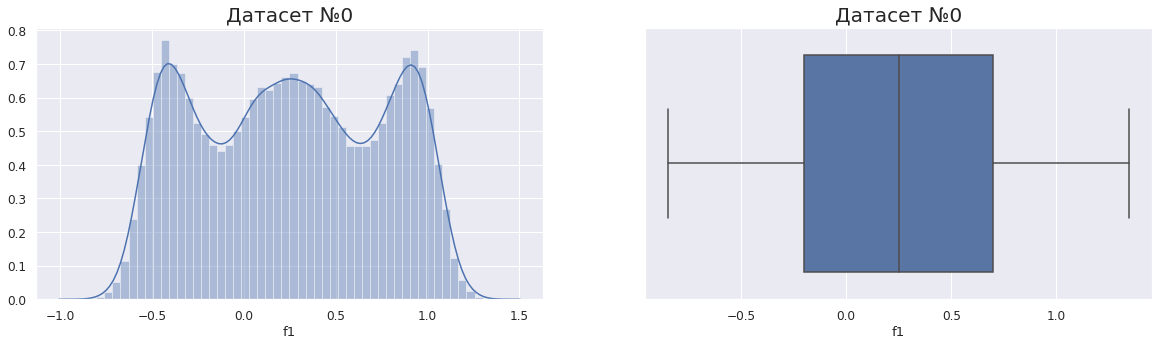

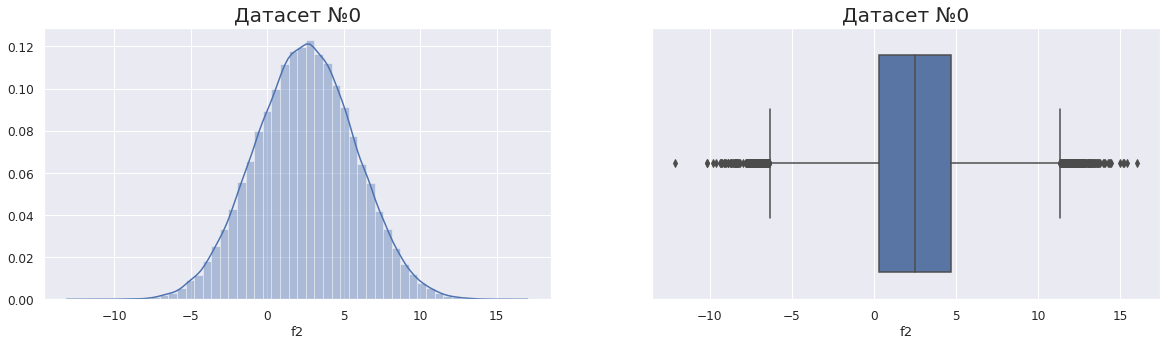

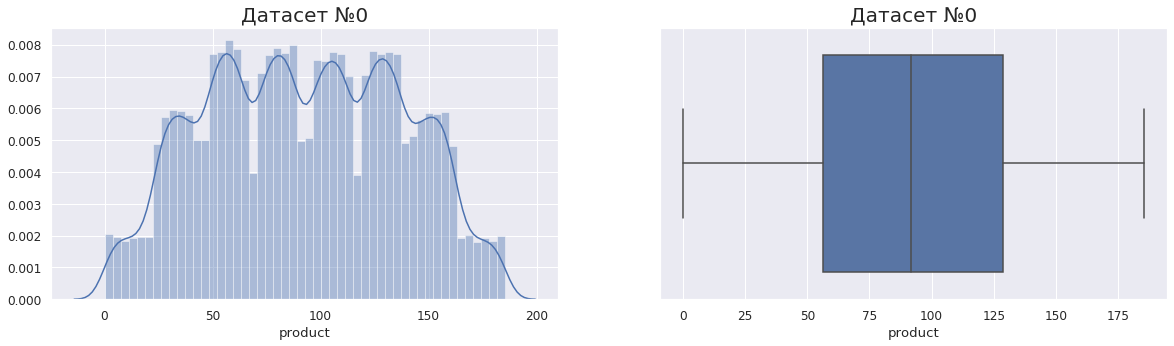

In [11]:
data = data0
title = 0

display(adventure_time(data, 'f0'))
display(adventure_time(data, 'f1'))
display(adventure_time(data, 'f2'))
display(adventure_time(data, 'product'))

In [12]:
data0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


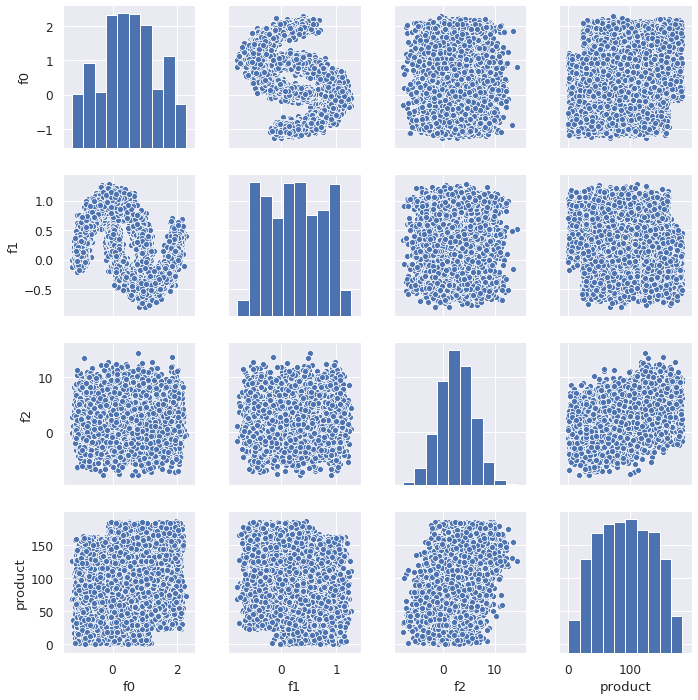

In [13]:
sns.pairplot(data0.sample(frac=0.1));

* Видим, что в регионе data0 признак f0 с медианой 0.5 имеет четыре пика: -1, 0, 1 и 2, не имеет выбросов данных.  
* Признак f1 так же не имеет выбросов, и с медианой 0.25 имеет три пика: -0.5, 0.25 и 1.  
* Признак f2 имеет выбросы и нормальное распределение данных с медианой 2.5.  
* Целевой признак без выбросов и имеет 4 основных пика и два поменьше.
* Данные признаков f0 и f1 не похожи на реальные.
* Средняя корреляция между f2 и product.

### Датасет 1

In [14]:
display(data1.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


None

None

None

None

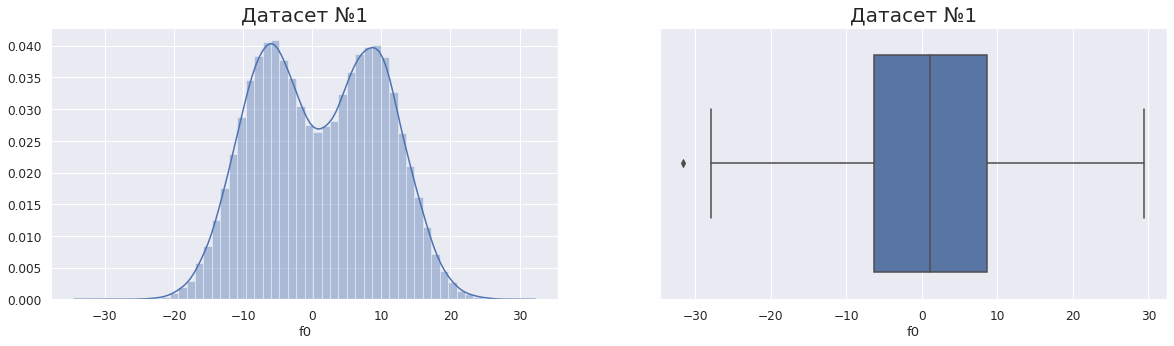

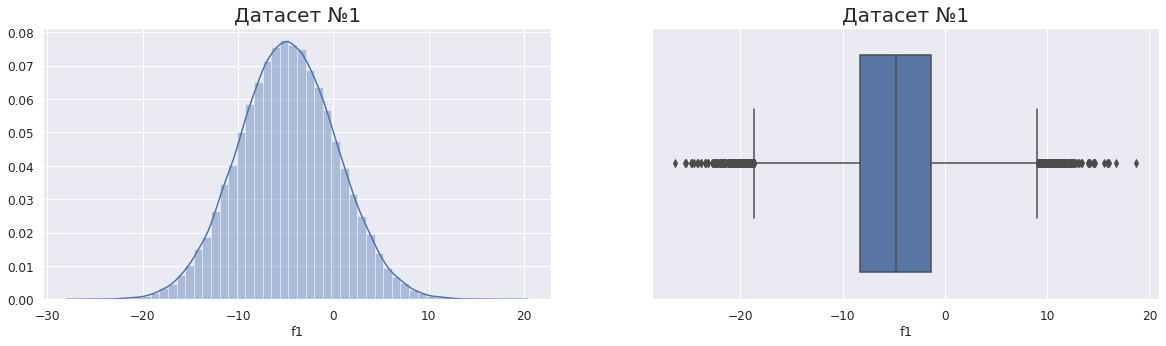

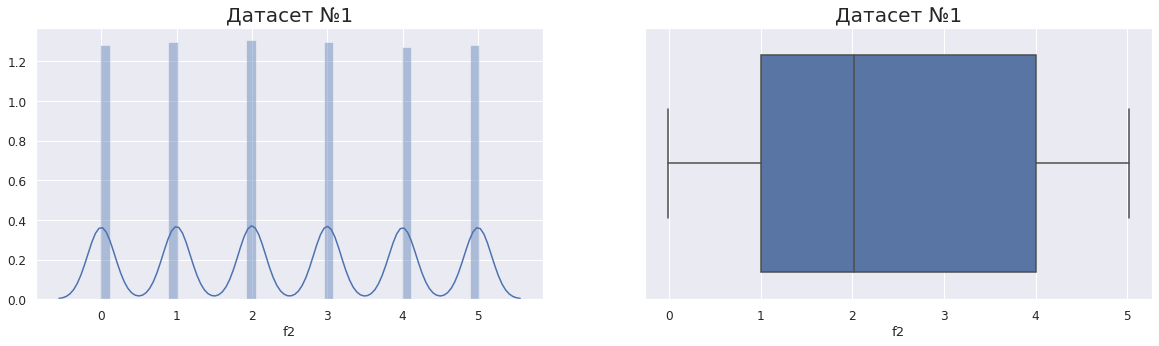

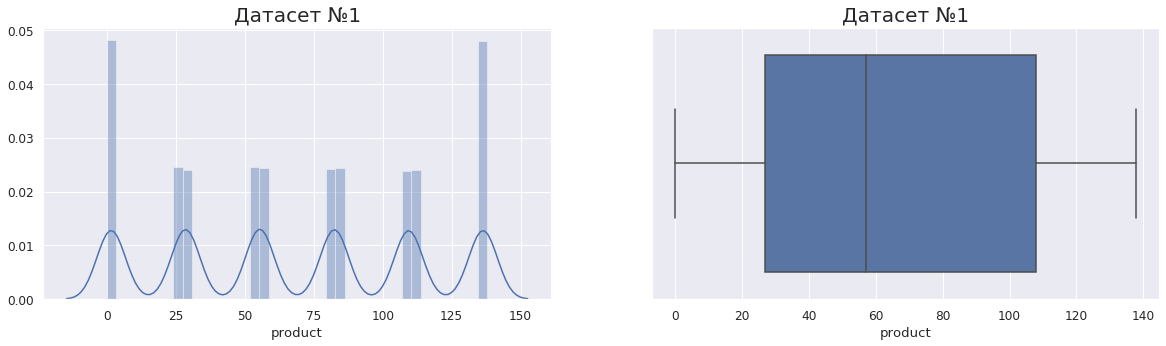

In [15]:
data = data1
title = 1

display(adventure_time(data, 'f0'))
display(adventure_time(data, 'f1'))
display(adventure_time(data, 'f2'))
display(adventure_time(data, 'product'))

In [16]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


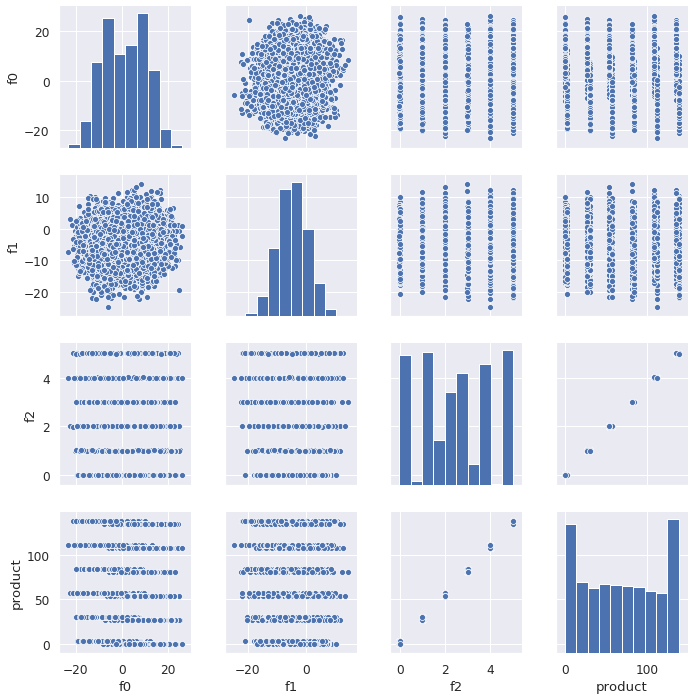

In [17]:
sns.pairplot(data1.sample(frac=0.1));

* В регионе data1 признак f0 имеет 2 пика: -10 и 10, медиана 1.15, отрицательные выбросы.  
* Признак f1 иеет нормальное распределение с медианой -4.8, наблюдаем выбросы.
* В f2 и 'product' данные скошены вправо и волнообразный вид (12 уникальных значений).
* Видим сильную корреляцию между f2 и product.

### Датасет 2

In [18]:
display(data2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


None

None

None

None

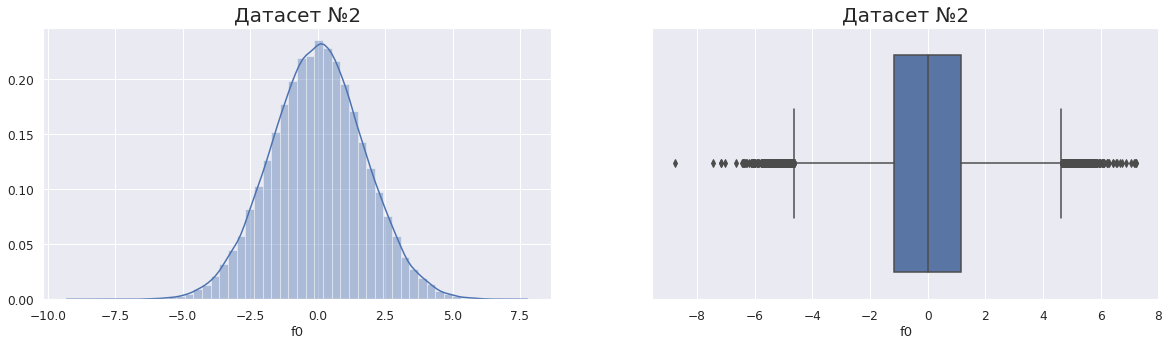

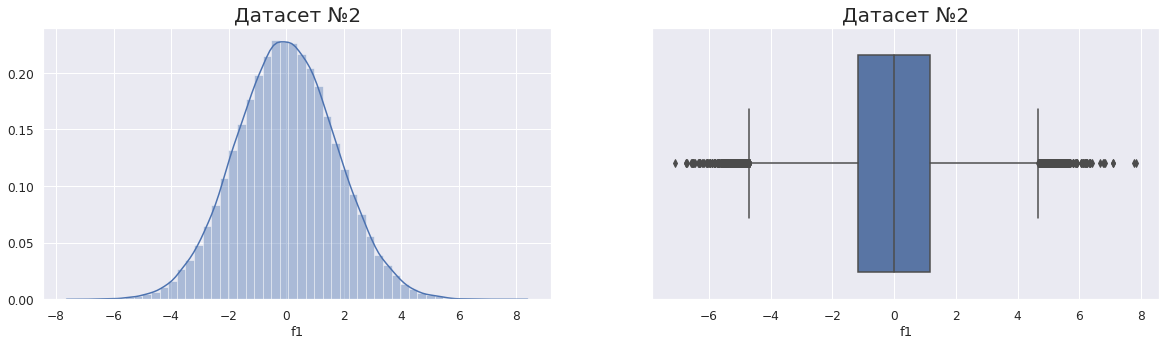

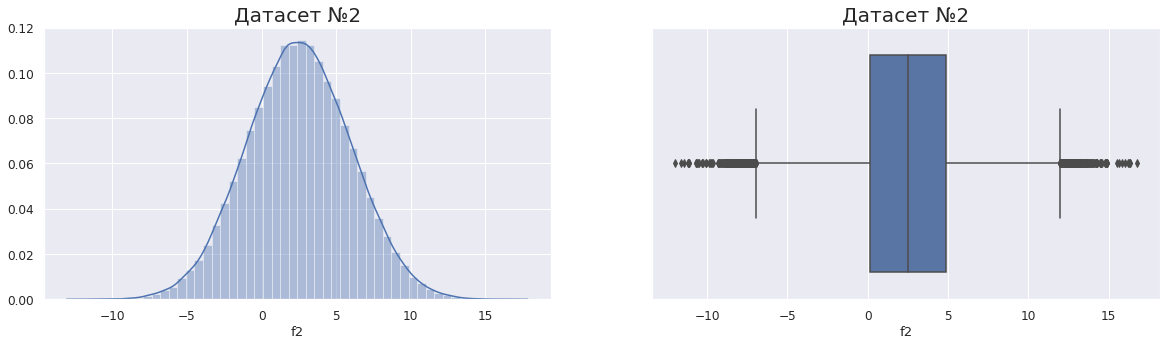

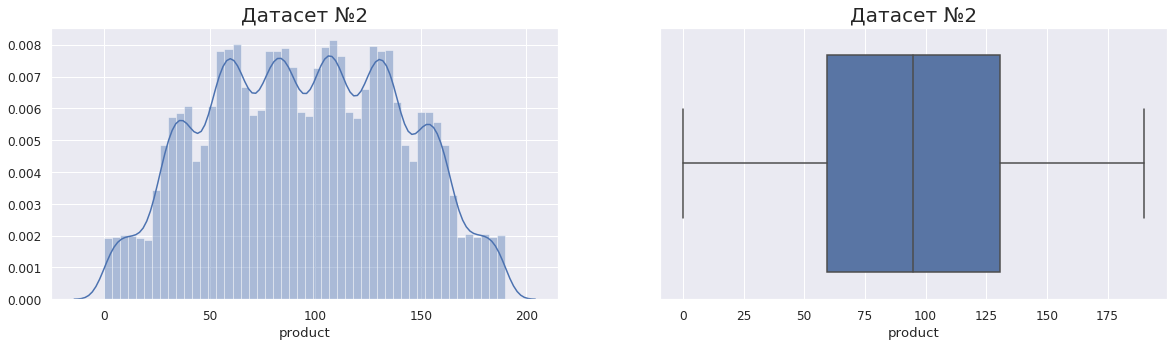

In [19]:
data = data2
title = 2

display(adventure_time(data, 'f0'))
display(adventure_time(data, 'f1'))
display(adventure_time(data, 'f2'))
display(adventure_time(data, 'product'))

In [20]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


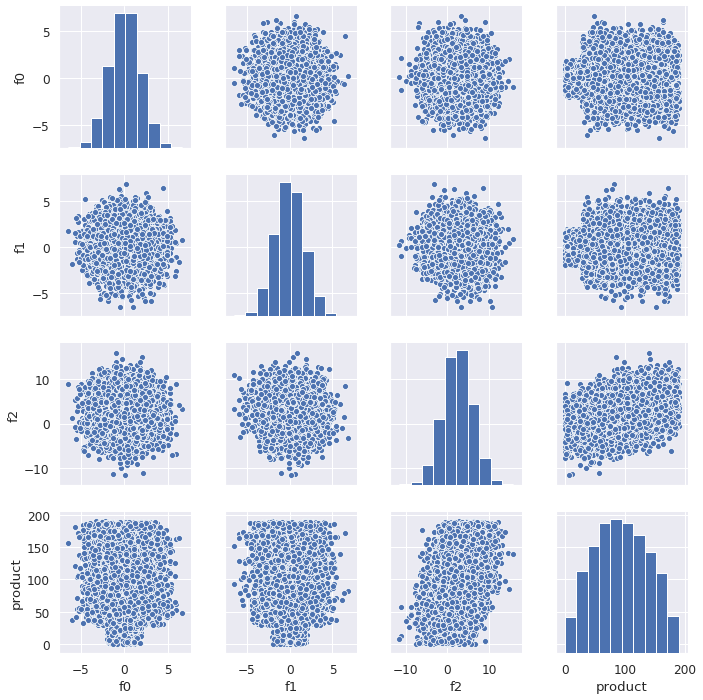

In [21]:
sns.pairplot(data2.sample(frac=0.1));

* Признаки имеют нормальное распределение данных с выбросами. 
* Значения 'product' похожи на те же данные в data0 - так же имеют 4 основных пика и два поменьше. Это может говорить о перспективности данных регионов.
* Средняя корреляция между f2 и product.

## Обучение и проверка модели

In [22]:
def lin_reg_mod(data, target_column):
    
    # выделим признаки
    target = data[target_column]
    features = data.drop([target_column,'id'], axis=1) #если не удалить еще и id то будет ошибка, что текстовое поле
    
    # разобьём данные на тестовую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    
    parameters = {'fit_intercept':[True,False], 'copy_X':[True, False], 'normalize':[True,False]}
    model = GridSearchCV(estimator=LinearRegression(), param_grid=parameters, cv=5)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
        
    # посчитаем метрики
    metrics = {}
    metrics['mean_fact_target'] = round(target.mean(),4) # средняя всего фактического сырья
    metrics['mean_predict_valid'] =  round(predicted_valid.mean(),4) # средняя предсказанного сырья
    metrics['mse'] =  round(mean_squared_error(target_valid, predicted_valid),4)
    metrics['rmse'] =  round(metrics['mse'] ** 0.5,4)
    metrics["predicted_valid"] = predicted_valid
    metrics["target_valid"] = target_valid
    
    return metrics

In [23]:
target_column = 'product'

metrics0 = lin_reg_mod(data0, target_column)
metrics1 = lin_reg_mod(data1, target_column)
metrics2 = lin_reg_mod(data2, target_column)

In [24]:
print(f'Средняя предсказанного сырья Датасет 0: {metrics0["mean_predict_valid"]}')
print(f'RMSE:                                   {metrics0["rmse"]}')
print()
print(f'Средняя предсказанного сырья Датасет 1: {metrics1["mean_predict_valid"]}')
print(f'RMSE:                                   {metrics1["rmse"] }')
print()
print(f'Средняя предсказанного сырья Датасет 2: {metrics2["mean_predict_valid"]}')
print(f'RMSE:                                   {metrics2["rmse"]}')
print()

Средняя предсказанного сырья Датасет 0: 92.5926
RMSE:                                   37.5794

Средняя предсказанного сырья Датасет 1: 68.7285
RMSE:                                   0.8931

Средняя предсказанного сырья Датасет 2: 94.965
RMSE:                                   40.0297



Чем ближе корень из средней квадратичной ошибки (RMSE) к нулю тем лучше.

Наша модель с большей точностью предсказала средний запас сырья для региона data1.

## Подготовка к расчёту прибыли

Из условий задачи известно, что:  

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  

Введём переменные для этих значений.

In [39]:
COUNT_OF_WELLS = 200 # количество скважин
BUDGET = 10e9 # бюджет
PRICE_ONE_THOUSAND_BARRELS = 450e3 # цена за 1000 баррелей
PRICE_ONE_WELL = BUDGET / COUNT_OF_WELLS # стоимость разработки одной скважины
print('Cтоимость разработки одной скважины:', PRICE_ONE_WELL)
print('Для безубыточной разработки региона необходимо единиц сырья:', round(BUDGET / PRICE_ONE_THOUSAND_BARRELS))
print('B среднем каждая из 200 разрабатываемых скважин должна содержать', round((BUDGET / PRICE_ONE_THOUSAND_BARRELS)/200), 'единиц сырья.')
print('Средний запас в регионах:', round(data0['product'].mean()),',', round(data1['product'].mean()),'и', round(data2['product'].mean()), 'соответственно.')


Cтоимость разработки одной скважины: 50000000.0
Для безубыточной разработки региона необходимо единиц сырья: 22222
B среднем каждая из 200 разрабатываемых скважин должна содержать 111 единиц сырья.
Средний запас в регионах: 93 , 69 и 95 соответственно.


По предсказаниям в среднем такого объема нет ни в одном регионе.  

Подготовим данные по регионам для дальнейших расчетов, отбросив признаки.

In [40]:
region0 = pd.DataFrame(metrics0["target_valid"])
region0['predicted'] = metrics0["predicted_valid"]
region0['profit'] = metrics0["target_valid"] * PRICE_ONE_THOUSAND_BARRELS
region0['region'] = 0

region1 = pd.DataFrame(metrics1["target_valid"])
region1['predicted'] = metrics1["predicted_valid"]
region1['profit'] = metrics1["target_valid"] * PRICE_ONE_THOUSAND_BARRELS
region1['region'] = 1

region2 = pd.DataFrame(metrics2["target_valid"])
region2['predicted'] = metrics2["predicted_valid"]
region2['profit'] = metrics2["target_valid"] * PRICE_ONE_THOUSAND_BARRELS
region2['region'] = 2

In [41]:
df = pd.concat([region0, region1, region2])
df.pivot_table(index='region')

,predicted,product,profit
region,,,
0,92.592568,92.078597,4.143537e+07
1,68.728547,68.723136,3.092541e+07
2,94.965046,94.884233,4.269790e+07


In [42]:
# Выберем скважины с максимальными значениями предсказаний
max_pred0 = region0.sort_values(by='predicted', ascending=False)[:200]
max_pred1 = region1.sort_values(by='predicted', ascending=False)[:200]
max_pred2 = region2.sort_values(by='predicted', ascending=False)[:200]

In [43]:
# Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
sum_oil0 = math.floor(max_pred0['product'].sum())
print(f'Целевое значение объёма сырья DataFrame_0: { sum_oil0 } тыс.баррелей')
sum_oil1 = math.floor(max_pred1['product'].sum())
print(f'Целевое значение объёма сырья DataFrame_1: { sum_oil1 } тыс.баррелей')
sum_oil2 = math.floor(max_pred2['product'].sum())
print(f'Целевое значение объёма сырья DataFrame_2: { sum_oil2 } тыс.баррелей')

Целевое значение объёма сырья DataFrame_0: 29601 тыс.баррелей
Целевое значение объёма сырья DataFrame_1: 27589 тыс.баррелей
Целевое значение объёма сырья DataFrame_2: 28245 тыс.баррелей


In [44]:
profit0 = round(((sum_oil0 * PRICE_ONE_THOUSAND_BARRELS) - BUDGET)/10e8, 4)
print('Прибыль для полученного объёма сырья DataFrame_0: {:.4f} млрд.руб.'.format(profit0))
profit1 = round(((sum_oil1 * PRICE_ONE_THOUSAND_BARRELS) - BUDGET)/10e8, 4)
print('Прибыль для полученного объёма сырья DataFrame_1: {:.4f} млрд.руб.'.format(profit1))
profit2 = round(((sum_oil2 * PRICE_ONE_THOUSAND_BARRELS) - BUDGET)/10e8,4)
print('Прибыль для полученного объёма сырья DataFrame_2: {:.4f} млрд.руб.'.format(profit2))

Прибыль для полученного объёма сырья DataFrame_0: 3.3205 млрд.руб.
Прибыль для полученного объёма сырья DataFrame_1: 2.4150 млрд.руб.
Прибыль для полученного объёма сырья DataFrame_2: 2.7102 млрд.руб.


Отобрали по 200 скважин в каждом регионе с наибольшей мощностью которую предсказала модель. Просуммировали реальные данные по этим скажинам. Посчитали прибыль путём вычитания из всех денег которые принесут все скважины, бюджета на разработку в данном регионе. По предварительным данным в каждой регионе прибыль от разработки от 2,4 до 3,32 миллиарда рублей.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли и найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков.


In [45]:
def get_values(df):
    global budget
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000): 
        data = df.sample(n=500, random_state=state, replace=True)
        max_pred = data.sort_values(by='predicted', ascending=False)[:200]
        income = (max_pred['profit'].sum() - BUDGET)/1_000_000_000
        values.append(income)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    hight = values.quantile(0.975)
    loss = values[values<0]
    mean = values.mean()
    print("Средняя прибыль: {:.6f} млрд.руб.".format(mean))
    print("2,5%-квантиль: {:.6f} млрд.руб.".format(lower))
    print("97,5%-квантиль: {:.6f} млрд.руб.".format(hight))
    print("Количество убыточных экспериментов:", loss.count())
    print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))
    print("Максимальный убыток:", loss.min())
    print("Максимальная прибыль:", values.max())
    print("Количество экспериментов:", len(values))

In [46]:
print('Регион 0:')
get_values(region0)

Регион 0:
Средняя прибыль: 0.396165 млрд.руб.
2,5%-квантиль: -0.111216 млрд.руб.
97,5%-квантиль: 0.909767 млрд.руб.
Количество убыточных экспериментов: 69
Вероятность убытков: 6.90%
Максимальный убыток: -0.3695671193500767
Максимальная прибыль: 1.3492668656302222
Количество экспериментов: 1000


In [47]:
print('Регион 1:')
get_values(region1)

Регион 1:
Средняя прибыль: 0.456045 млрд.руб.
2,5%-квантиль: 0.033821 млрд.руб.
97,5%-квантиль: 0.852289 млрд.руб.
Количество убыточных экспериментов: 15
Вероятность убытков: 1.50%
Максимальный убыток: -0.1922681091210556
Максимальная прибыль: 1.1540472794043521
Количество экспериментов: 1000


In [48]:
print('Регион 2:')
get_values(region2)

Регион 2:
Средняя прибыль: 0.404404 млрд.руб.
2,5%-квантиль: -0.163350 млрд.руб.
97,5%-квантиль: 0.950360 млрд.руб.
Количество убыточных экспериментов: 76
Вероятность убытков: 7.60%
Максимальный убыток: -0.4178569542016144
Максимальная прибыль: 1.3305932187701168
Количество экспериментов: 1000


Исходя из результатов, если брать 500 скважин произвольным образом, и из них 200 то в любом регионе прибыль будет, но не такая высокая как если брать по предсказанным моделью:

* Регион 0: 3.3205 млрд.руб.
* Регион 1: 2.4150 млрд.руб.
* Регион 2: 2.7102 млрд.руб.

По предсказанию модели лидер более прибыльным является регион 0: 3.3205 млрд.руб.

У региона 1 вероятность убытков всего 1.5% и в пределах доверительного интервала 95% добыча все равно остаётся без убыточной, тем более средняя прибыль выше чем в других регионах:

* Региона 0: 0.396165 млрд.руб.
* Регион 1: 0.456045 млрд.руб. 
* Регион 2: 0.404404 млрд.руб.

## Вывод  

На первом шаге мы загрузили и изучили данные, построили графики. Проверка на корреляцию показала в Датасете 1 очень сильную связь между целевым признаком и признаком-столбцом "f2".

Далее были разработаны и обучены три модели Линейной регрессии, параметры подобраны с помощью GridSearchCV для каждого датасета. Изучены метрики: самое низкое значение RMSE = 0.8931 у Датасета 1.  

Далее была посчитана прибыль по предсказанниям моделей.

Хоть здесь и лидер Датасет 0: 3.3205 млрд.руб, далее Датасет 2: 2.7102 млрд.руб., всё же техника Bootstrap показывает на высокие риски (вероятность убытков > 2.5%).

Судя по анализу Bootstrap даёт нам явно понять, что регион DataFrame_1, будет предпочтительнее, так как при разработке 200 скважин, вероятность убытков наименьшая.